In [1]:
# 1.1) Standard imports
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1.2) For reading PTB-XL .mat and header files
from scipy.io import loadmat
from scipy.signal import resample, find_peaks

# 1.3) For training
import tensorflow as tf

# 1.4) Create output directories if not exist
os.makedirs("arrhythmia_gan_outputs", exist_ok=True)


In [2]:
# 1.5) Unzip PTB-XL if needed
zip_path    = Path("archive.zip")
extract_dir = Path("ptbxl_unzipped")

if not extract_dir.exists():
    import zipfile
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_dir)
    print(f"Unzipped '{zip_path}' → '{extract_dir}/'")
else:
    print(f"'{extract_dir}' already exists, skipping unzip.")


'ptbxl_unzipped' already exists, skipping unzip.


In [3]:
# 2.1) Helper: load .mat and corresponding .hea (not strictly needed yet)
def load_ptbxl_mat(mat_filename):
    """
    Loads a PTB-XL .mat file and returns a 12×orig_length NumPy array.
    """
    data = loadmat(mat_filename)
    ecg = np.asarray(data['val'], dtype=np.float32)  # shape = (12, orig_length)
    return ecg

# 2.2) Helper: downsample a single 12×orig_length ECG → 1000×12
def downsample_ecg(ecg_12xN, target_len=1000):
    """
    ecg_12xN: shape (12, original_length)
    Returns: shape (target_len, 12), each lead downsampled via Fourier-based resample.
    """
    n_leads, orig_len = ecg_12xN.shape
    out = np.zeros((target_len, n_leads), dtype=np.float32)
    for i in range(n_leads):
        out[:, i] = resample(ecg_12xN[i], target_len)
    return out

# 2.3) Loop over every .mat in WFDB folder
wfdb_folder = "ptbxl_unzipped/WFDB"
mat_files    = sorted([f for f in os.listdir(wfdb_folder) if f.endswith(".mat")])

ECGs_all = []
hea_files = []

for fname in mat_files:
    mat_path = os.path.join(wfdb_folder, fname)
    # Load raw ECG (12 × orig_length)
    ecg_raw = load_ptbxl_mat(mat_path)               # shape (12, orig_len)
    # Downsample → (1000, 12)
    ecg_ds  = downsample_ecg(ecg_raw, target_len=1000)
    # Convert µV → mV
    ecg_ds /= 1000.0
    ECGs_all.append(ecg_ds)

    # Also store header path for metadata
    hea_path = mat_path.replace(".mat", ".hea")
    hea_files.append(hea_path)

ECGs_all = np.stack(ECGs_all, axis=0)  # shape = (N_records, 1000, 12)
print(f"Loaded and downsampled all ECGs → shape = {ECGs_all.shape}")


Loaded and downsampled all ECGs → shape = (21837, 1000, 12)


In [5]:
# ─── Step 3 (revised): Filter for Arrhythmic (“Rare”) ECGs using SNOMED codes ───────────

import os

# 3.1) Define the set of SNOMED codes in PTB-XL that correspond to arrhythmias.
#     (This list is not exhaustive, but contains the most common arrhythmias in PTB-XL.)
#
#     You can expand this set with any other SNOMED codes you care about.
arrhythmia_snomed = {
    "427172004",  # AFIB: Atrial fibrillation
    "713426002",  # PVC: Premature ventricular contractions
    "713417000",  # SVT: Supraventricular tachycardia
    "713426001",  # AFL: Atrial flutter
    "164889003",  # MI – not an arrhythmia, but often included (optional)
    "164909002",  # RBBB: Right bundle branch block
    "164909005",  # LBBB: Left bundle branch block
    "426783006",  # CHB: Complete AV block
    "426627000",  # I-AVB: First-degree AV block
    # …you can add more SNOMED codes here if you want other rhythms…
}

# 3.2) Helper to parse the "#Dx:" line into a list of SNOMED code strings
def parse_header_for_snomed(header_lines):
    """
    Given the lines of a .hea file (a list of strings),
    finds the line beginning with '#Dx:' and returns a list of SNOMED code strings.
    """
    for line in header_lines:
        if line.startswith("#Dx:"):
            # Remove '#Dx:', strip whitespace, split on comma
            codes = [token.strip() for token in line.replace("#Dx:", "").strip().split(",")]
            return codes
    return []


# 3.3) Re‐load (or re‐use) the list of header paths (hea_files) and ECG array (ECGs_all).
#     In our previous step 2, we collected both arrays: `ECGs_all` and `hea_files`.
#
#     If you haven’t stored `hea_files` already, re‐create it like this:
wfdb_folder = "ptbxl_unzipped/WFDB"
mat_files    = sorted([f for f in os.listdir(wfdb_folder) if f.endswith(".mat")])
hea_files    = [os.path.join(wfdb_folder, fname.replace(".mat", ".hea")) for fname in mat_files]

# 3.4) Now loop over each header file, parse its SNOMED codes, and keep only those whose
#     code list intersects our `arrhythmia_snomed` set.

arr_indices = []
for idx, hea_path in enumerate(hea_files):
    with open(hea_path, 'r') as f:
        header_lines = f.readlines()
    snomed_codes = parse_header_for_snomed(header_lines)
    # Check if any of the codes in this record belongs to arrhythmia_snomed
    if any(code in arrhythmia_snomed for code in snomed_codes):
        arr_indices.append(idx)

print(f"Found {len(arr_indices)} arrhythmic records out of {len(ECGs_all)} total.")

# 3.5) Extract those arrhythmic ECGs into ECGs_arr
ECGs_arr = ECGs_all[arr_indices]  # shape = (#arrhythmias, 1000, 12)
print(f"Arrhythmia‐only ECG array shape  = {ECGs_arr.shape}")


Found 19811 arrhythmic records out of 21837 total.
Arrhythmia‐only ECG array shape  = (19811, 1000, 12)


In [6]:
from sklearn.model_selection import train_test_split

# 4.1) Split EC_Gs_arr into train vs. test (80% train, 20% test)
ECGs_arr_train, ECGs_arr_test = train_test_split(
    ECGs_arr,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Arrhythmia train shape = {ECGs_arr_train.shape}")
print(f"Arrhythmia test  shape = {ECGs_arr_test.shape}")


Arrhythmia train shape = (15848, 1000, 12)
Arrhythmia test  shape = (3963, 1000, 12)


In [7]:
# 5.1) Inception‐style block
def _inception_module(x):
    conv1 = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu")(x)
    conv3 = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    conv5 = tf.keras.layers.Conv1D(32, 5, padding="same", activation="relu")(x)
    pool  = tf.keras.layers.MaxPool1D(pool_size=3, strides=1, padding="same")(x)
    pool_conv = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu")(pool)
    return tf.keras.layers.Concatenate(axis=-1)([conv1, conv3, conv5, pool_conv])

# 5.2) Residual shortcut
def _shortcut_layer(inp, x):
    conv = tf.keras.layers.Conv1D(x.shape[-1], kernel_size=1, padding="same", activation="relu")(inp)
    return tf.keras.layers.Add()([x, conv])

# 5.3) Build discriminator model
def build_discriminator(input_shape=(1000, 12), depth=2, use_residual=True):
    """
    Constructs an Inception‐ResNet style 1D CNN returning a scalar probability.
    """
    inp = tf.keras.layers.Input(shape=input_shape)
    x   = inp
    res = inp

    # Stack `depth` Inception + optional residual blocks
    for d in range(depth):
        x = _inception_module(x)
        if use_residual:
            x = _shortcut_layer(res, x)
            res = x

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.models.Model(inputs=inp, outputs=out, name="Discriminator")

    # CFD: during GAN training, we supply our own optimizer & loss; here we just compile for metrics.
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
        metrics = [tf.keras.metrics.AUC(name="auroc")]
    )
    return model

# 5.4) Instantiate
disc_arr = build_discriminator(input_shape=(1000, 12), depth=2, use_residual=True)
disc_arr.summary()


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1000, 12)  │          0 │ input_layer[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1000, 32)  │        416 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1000, 32)  │      1,184 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1000, 32)  │      1,952 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1000, 32)  │        416 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1000, 128) │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1000, 128) │      1,664 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1000, 128) │          0 │ concatenate[0][0… │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1000, 128) │          0 │ add[0][0]         │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1000, 32)  │      4,128 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1000, 32)  │     12,320 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1000, 32)  │     20,512 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1000, 32)  │      4,128 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1000, 128) │          0 │ conv1d_5[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1000, 128) │     16,512 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1000, 128) │          0 │ concatenate_1[0]… │
│                     │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ global_average_p

 Total params: 63,361 (247.50 KB)

 Trainable params: 63,361 (247.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def build_generator(latent_dim=12):
    """
    Inputs: noise vector z of shape (1, latent_dim).
    Outputs: a (1000, 12) ECG in [-1,1] range (later interpret as ±1 mV).
    """
    model = tf.keras.Sequential(name="ECG_Generator")
    # 1) Dense → BatchNorm → LeakyReLU → reshape to (1000,12)
    model.add(tf.keras.layers.Dense(12 * 1000, use_bias=False, input_shape=(1, latent_dim)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((1000, 12)))  # now shape = (batch, 1000, 12)

    # 2) Conv1DTranspose(128) → BatchNorm → LeakyReLU
    model.add(tf.keras.layers.Conv1DTranspose(128, kernel_size=5, strides=1, padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # 3) Conv1DTranspose(64) → BatchNorm → LeakyReLU
    model.add(tf.keras.layers.Conv1DTranspose(64, kernel_size=5, strides=1, padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # 4) Final Conv1DTranspose(12) → tanh (no bias)
    model.add(tf.keras.layers.Conv1DTranspose(
        12, kernel_size=5, strides=1, padding="same", activation="tanh", use_bias=False
    ))

    return model

# 6.1) Instantiate
gen_arr = build_generator(latent_dim=12)
gen_arr.summary()


c:\Users\Bio-Optics\anaconda3\envs\test\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "ECG_Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1, 12000)       │       144,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 12000)       │        48,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1, 12000)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1000, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 1000, 128)      │         7,680 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 1000, 64)       │        40,960 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 1000, 12)       │         3,840 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,248 (958.00 KB)

 Trainable params: 220,864 (862.75 KB)

 Non-trainable params: 24,384 (95.25 KB)

In [12]:
from sklearn.metrics import roc_auc_score

def safe_roc_auc(y_true, y_pred_probs):
    """
    Only compute ROC AUC if y_true contains both 0 and 1.
    Otherwise return np.nan.
    """
    unique_labels = np.unique(y_true)
    if len(unique_labels) != 2:
        return np.nan
    return roc_auc_score(y_true, y_pred_probs)

def train_gan_on_arrhythmia(gen, desc, ECGs_arr, 
                            epochs=100, batch_size=16, latent_dim=12, 
                            lr_desc=2e-4, lr_gen=4e-4, 
                            checkpoint_interval=10, 
                            save_dir="arrhythmia_gan_outputs"):
    """
    Trains a GAN on arrhythmic ECGs (ECGs_arr: shape = (N_arr, 1000,12)).
    Uses the same D & G architectures defined above.
    Saves final weights + loss/AUC curves + checkpoint ECG images to `save_dir`.
    """

    os.makedirs(save_dir, exist_ok=True)

    # 1) Prepare metric lists
    all_d_losses = []
    all_g_losses = []
    all_d_auc    = []
    all_g_auc    = []

    # 2) Create optimizers
    opt_desc = tf.keras.optimizers.Adam(learning_rate=lr_desc, beta_1=0.5, beta_2=0.9)
    opt_gen  = tf.keras.optimizers.Adam(learning_rate=lr_gen,  beta_1=0.5, beta_2=0.9)

    half_batch      = batch_size // 2
    steps_per_epoch = max(1, ECGs_arr.shape[0] // batch_size)

    # 3) Helper: sample real arrhythmia ECGs
    def generate_real_arr_batch(arr_ecgs, n):
        idx = np.random.choice(arr_ecgs.shape[0], n, replace=False)
        X   = arr_ecgs[idx]                 # shape = (n, 1000, 12)
        y   = tf.ones((n, 1))               # label=1 for real
        return X, y

    # 4) Helper: sample fake ECGs from generator
    def generate_fake_arr_batch(gen_model, n):
        z = np.random.randn(n, 1, latent_dim).astype("float32")
        fake = gen_model(z, training=False)  # shape = (n, 1000,12)
        y    = np.zeros((n, 1))              # label=0 for fake
        return fake, y

    # 5) Training loop
    for epoch in range(1, epochs + 1):
        epoch_d_losses = []
        epoch_g_losses = []
        epoch_d_auc    = []
        epoch_g_auc    = []

        # (Optionally decay LR)
        if epoch > 1 and epoch % 20 == 0:
            new_lr_desc = opt_desc.learning_rate * 0.5
            new_lr_gen  = opt_gen.learning_rate  * 0.5
            opt_desc.learning_rate.assign(new_lr_desc)
            opt_gen.learning_rate.assign(new_lr_gen)
            print(f"→ Halved LRs: lr_desc={new_lr_desc:.2e}, lr_gen={new_lr_gen:.2e}")

        for step in range(steps_per_epoch):
            # A) Train Discriminator on Arrhythmia Real vs. Fake
            X_real, y_real = generate_real_arr_batch(ECGs_arr, half_batch)
            X_fake, y_fake = generate_fake_arr_batch(gen, half_batch)

            # Stack real+fake
            X_disc = np.vstack([X_real, X_fake])  # (batch_size, 1000,12)
            y_disc = np.vstack([y_real, y_fake])  # (batch_size,1)

            # Shuffle
            perm = np.random.permutation(batch_size)
            Xd  = X_disc[perm]
            yd  = y_disc[perm]

            # Compute D loss + update
            with tf.GradientTape() as tape_d:
                pred_d = desc(Xd, training=True)                        # (batch_size,1)
                loss_d = tf.keras.losses.binary_crossentropy(yd, pred_d)
            grads_d = tape_d.gradient(loss_d, desc.trainable_variables)
            opt_desc.apply_gradients(zip(grads_d, desc.trainable_variables))

            # Safe AUC for D
            yd_np   = yd.flatten()
            predd_np= pred_d.numpy().flatten()
            auc_d   = safe_roc_auc(yd_np, predd_np)

            # B) Train Generator to fool D
            z_g        = np.random.randn(batch_size, 1, latent_dim).astype("float32")
            y_g_target = tf.ones((batch_size, 1))  # want D(G(z)) → 1

            with tf.GradientTape() as tape_g:
                fake_for_g = gen(z_g, training=True)                        # (batch_size,1000,12)
                pred_g     = desc(fake_for_g, training=False)               # freeze D
                loss_g     = tf.keras.losses.binary_crossentropy(y_g_target, pred_g)
            grads_g = tape_g.gradient(loss_g, gen.trainable_variables)
            opt_gen.apply_gradients(zip(grads_g, gen.trainable_variables))

            # Safe AUC for G
            yg_np    = y_g_target.numpy().flatten()
            predg_np = pred_g.numpy().flatten()
            auc_g    = safe_roc_auc(yg_np, predg_np)

            # Record step‐metrics
            epoch_d_losses.append(np.mean(loss_d.numpy()))
            epoch_g_losses.append(np.mean(loss_g.numpy()))
            epoch_d_auc.append(auc_d)
            epoch_g_auc.append(auc_g)

        # End of epoch → aggregate
        mean_d_loss = np.mean(epoch_d_losses)
        mean_g_loss = np.mean(epoch_g_losses)
        mean_d_auc  = np.nanmean(epoch_d_auc)
        mean_g_auc  = np.nanmean(epoch_g_auc)

        all_d_losses.append(mean_d_loss)
        all_g_losses.append(mean_g_loss)
        all_d_auc.append(mean_d_auc)
        all_g_auc.append(mean_g_auc)

        print(f"Epoch {epoch}/{epochs}  |  D_loss={mean_d_loss:.4f}, D_AUC={mean_d_auc:.4f}  |  "
              f"G_loss={mean_g_loss:.4f}, G_AUC={mean_g_auc:.4f}")

        # Checkpoint: every `checkpoint_interval` epochs, plot 1 fake vs. real (arrhythmia lead I)
        if epoch % checkpoint_interval == 0:
            # Generate one fake arrhythmia
            z_plot = np.random.randn(1, 1, latent_dim).astype("float32")
            fake_p = gen(z_plot, training=False).numpy()[0,:,:]
            # Sample one random real arrhythmia
            real_idx = np.random.randint(0, ECGs_arr.shape[0])
            real_p   = ECGs_arr[real_idx]   # shape = (1000,12)

            plt.figure(figsize=(16,4))
            plt.subplot(1,2,1)
            plt.plot(fake_p[:,0], color="crimson")
            plt.title(f"Epoch {epoch} – Fake Arrhythmia (Lead I)")
            plt.subplot(1,2,2)
            plt.plot(real_p[:,0], color="black")
            plt.title(f"Epoch {epoch} – Real Arrhythmia (Lead I)")
            plt.savefig(f"{save_dir}/arr_ecg_epoch_{epoch}.png")
            plt.clf()

    # After all epochs, save final weights
    gen_path  = os.path.join(save_dir, "generator_arrhythmia_final.weights.h5")
    desc_path = os.path.join(save_dir, "discriminator_arrhythmia_final.weights.h5")

    gen.save_weights(gen_path)
    desc.save_weights(desc_path)
    print(f"\n✅ Arrhythmia‐GAN training complete. Weights saved to:\n  • {gen_path}\n  • {desc_path}")

    # Save loss & AUC curves
    epochs_arr = np.arange(1, epochs+1)
    plt.figure(figsize=(8,4))
    plt.plot(epochs_arr, all_d_losses, label="D_loss")
    plt.plot(epochs_arr, all_g_losses, label="G_loss")
    plt.title("GAN Losses (Arrhythmia Only)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{save_dir}/arr_loss_curve.png")
    plt.clf()

    plt.figure(figsize=(8,4))
    plt.plot(epochs_arr, all_d_auc, label="D_AUC")
    plt.plot(epochs_arr, all_g_auc, label="G_AUC")
    plt.title("GAN AUROC (Arrhythmia Only)")
    plt.xlabel("Epoch")
    plt.ylabel("AUROC")
    plt.legend()
    plt.savefig(f"{save_dir}/arr_auc_curve.png")
    plt.clf()

    return gen, desc, {
        "d_loss": all_d_losses,
        "g_loss": all_g_losses,
        "d_auc":  all_d_auc,
        "g_auc":  all_g_auc
    }


In [13]:
# 8.1) Define hyperparameters
epochs_arr       = 100
batch_size_arr   = 16
latent_dim       = 12
checkpoint_intvl = 10
save_directory   = "arrhythmia_gan_outputs"

# 8.2) Kick off training
trained_gen_arr, trained_desc_arr, history_arr = train_gan_on_arrhythmia(
    gen=gen_arr,
    desc=disc_arr,
    ECGs_arr=ECGs_arr_train,
    epochs=epochs_arr,
    batch_size=batch_size_arr,
    latent_dim=latent_dim,
    lr_desc=2e-4,
    lr_gen=4e-4,
    checkpoint_interval=checkpoint_intvl,
    save_dir=save_directory
)


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 1/100  |  D_loss=0.1282, D_AUC=0.9922  |  G_loss=0.5156, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 2/100  |  D_loss=0.0772, D_AUC=0.9907  |  G_loss=0.0872, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 3/100  |  D_loss=0.0867, D_AUC=0.9911  |  G_loss=0.2229, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 4/100  |  D_loss=0.1180, D_AUC=0.9863  |  G_loss=0.2941, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 5/100  |  D_loss=0.0642, D_AUC=0.9964  |  G_loss=0.1883, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 6/100  |  D_loss=0.0718, D_AUC=0.9931  |  G_loss=0.1894, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 7/100  |  D_loss=0.0681, D_AUC=0.9941  |  G_loss=0.0482, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 8/100  |  D_loss=0.0860, D_AUC=0.9922  |  G_loss=0.2037, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 9/100  |  D_loss=0.0662, D_AUC=0.9904  |  G_loss=0.0807, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 10/100  |  D_loss=0.1183, D_AUC=0.9924  |  G_loss=0.4896, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 11/100  |  D_loss=0.1271, D_AUC=0.9918  |  G_loss=0.6368, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 12/100  |  D_loss=0.0789, D_AUC=0.9933  |  G_loss=0.1994, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 13/100  |  D_loss=0.1053, D_AUC=0.9919  |  G_loss=0.3630, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 14/100  |  D_loss=0.1466, D_AUC=0.9929  |  G_loss=0.7538, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 15/100  |  D_loss=0.1097, D_AUC=0.9902  |  G_loss=0.5033, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 16/100  |  D_loss=0.1527, D_AUC=0.9888  |  G_loss=0.6678, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 17/100  |  D_loss=0.1126, D_AUC=0.9899  |  G_loss=0.4568, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 18/100  |  D_loss=0.1424, D_AUC=0.9926  |  G_loss=0.8367, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 19/100  |  D_loss=0.0915, D_AUC=0.9951  |  G_loss=0.3271, G_AUC=nan
→ Halved LRs: lr_desc=1.00e-04, lr_gen=2.00e-04


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 20/100  |  D_loss=0.2044, D_AUC=0.9694  |  G_loss=0.7116, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 21/100  |  D_loss=0.2028, D_AUC=0.9753  |  G_loss=0.9052, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 22/100  |  D_loss=0.2203, D_AUC=0.9748  |  G_loss=1.1588, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 23/100  |  D_loss=0.2412, D_AUC=0.9648  |  G_loss=1.4941, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 24/100  |  D_loss=0.2242, D_AUC=0.9746  |  G_loss=1.3743, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 25/100  |  D_loss=0.2403, D_AUC=0.9756  |  G_loss=1.3592, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 26/100  |  D_loss=0.2170, D_AUC=0.9848  |  G_loss=0.8267, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 27/100  |  D_loss=0.1968, D_AUC=0.9803  |  G_loss=1.3342, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 28/100  |  D_loss=0.2263, D_AUC=0.9766  |  G_loss=1.3320, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 29/100  |  D_loss=0.1978, D_AUC=0.9837  |  G_loss=1.1874, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 30/100  |  D_loss=0.1576, D_AUC=0.9848  |  G_loss=0.4950, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 31/100  |  D_loss=0.2059, D_AUC=0.9846  |  G_loss=1.3841, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 32/100  |  D_loss=0.1255, D_AUC=0.9930  |  G_loss=0.6223, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 33/100  |  D_loss=0.1248, D_AUC=0.9906  |  G_loss=0.4086, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 34/100  |  D_loss=0.1327, D_AUC=0.9892  |  G_loss=0.4077, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 35/100  |  D_loss=0.1662, D_AUC=0.9875  |  G_loss=0.9525, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 36/100  |  D_loss=0.1900, D_AUC=0.9870  |  G_loss=1.1117, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 37/100  |  D_loss=0.2059, D_AUC=0.9810  |  G_loss=1.2543, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 38/100  |  D_loss=0.2071, D_AUC=0.9803  |  G_loss=1.4459, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 39/100  |  D_loss=0.2170, D_AUC=0.9774  |  G_loss=1.3499, G_AUC=nan
→ Halved LRs: lr_desc=5.00e-05, lr_gen=1.00e-04


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 40/100  |  D_loss=0.2121, D_AUC=0.9675  |  G_loss=1.1834, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 41/100  |  D_loss=0.2494, D_AUC=0.9493  |  G_loss=1.6611, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 42/100  |  D_loss=0.2412, D_AUC=0.9574  |  G_loss=1.6668, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 43/100  |  D_loss=0.2261, D_AUC=0.9690  |  G_loss=1.5689, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 44/100  |  D_loss=0.2382, D_AUC=0.9554  |  G_loss=1.5044, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 45/100  |  D_loss=0.2385, D_AUC=0.9518  |  G_loss=1.5277, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 46/100  |  D_loss=0.2327, D_AUC=0.9572  |  G_loss=1.5569, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 47/100  |  D_loss=0.2223, D_AUC=0.9667  |  G_loss=1.3003, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 48/100  |  D_loss=0.1924, D_AUC=0.9795  |  G_loss=0.9437, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 49/100  |  D_loss=0.2366, D_AUC=0.9572  |  G_loss=1.6898, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 50/100  |  D_loss=0.1980, D_AUC=0.9786  |  G_loss=1.1523, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 51/100  |  D_loss=0.1806, D_AUC=0.9862  |  G_loss=0.8478, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 52/100  |  D_loss=0.2397, D_AUC=0.9539  |  G_loss=1.5349, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 53/100  |  D_loss=0.2327, D_AUC=0.9595  |  G_loss=1.8099, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 54/100  |  D_loss=0.2272, D_AUC=0.9674  |  G_loss=1.7664, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 55/100  |  D_loss=0.1676, D_AUC=0.9834  |  G_loss=1.2504, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 56/100  |  D_loss=0.1632, D_AUC=0.9738  |  G_loss=0.7029, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 57/100  |  D_loss=0.2281, D_AUC=0.9630  |  G_loss=1.7197, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 58/100  |  D_loss=0.2085, D_AUC=0.9775  |  G_loss=1.5719, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 59/100  |  D_loss=0.2319, D_AUC=0.9612  |  G_loss=1.7480, G_AUC=nan
→ Halved LRs: lr_desc=2.50e-05, lr_gen=5.00e-05


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 60/100  |  D_loss=0.2503, D_AUC=0.9459  |  G_loss=1.7255, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 61/100  |  D_loss=0.2515, D_AUC=0.9382  |  G_loss=1.7016, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 62/100  |  D_loss=0.2448, D_AUC=0.9446  |  G_loss=1.6564, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 63/100  |  D_loss=0.2454, D_AUC=0.9461  |  G_loss=1.7268, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 64/100  |  D_loss=0.2529, D_AUC=0.9376  |  G_loss=1.6750, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 65/100  |  D_loss=0.2284, D_AUC=0.9573  |  G_loss=1.7053, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 66/100  |  D_loss=0.2453, D_AUC=0.9367  |  G_loss=1.7697, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 67/100  |  D_loss=0.2337, D_AUC=0.9512  |  G_loss=1.8065, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 68/100  |  D_loss=0.2339, D_AUC=0.9499  |  G_loss=1.8261, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 69/100  |  D_loss=0.2321, D_AUC=0.9457  |  G_loss=1.8369, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 70/100  |  D_loss=0.2339, D_AUC=0.9411  |  G_loss=1.8170, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 71/100  |  D_loss=0.2357, D_AUC=0.9474  |  G_loss=1.7657, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 72/100  |  D_loss=0.2422, D_AUC=0.9475  |  G_loss=1.7370, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 73/100  |  D_loss=0.2321, D_AUC=0.9440  |  G_loss=1.8184, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 74/100  |  D_loss=0.2245, D_AUC=0.9495  |  G_loss=1.6366, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 75/100  |  D_loss=0.2279, D_AUC=0.9492  |  G_loss=1.6705, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 76/100  |  D_loss=0.2259, D_AUC=0.9486  |  G_loss=1.8930, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 77/100  |  D_loss=0.2275, D_AUC=0.9515  |  G_loss=1.8209, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 78/100  |  D_loss=0.2442, D_AUC=0.9379  |  G_loss=1.7708, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 79/100  |  D_loss=0.2264, D_AUC=0.9466  |  G_loss=1.7837, G_AUC=nan
→ Halved LRs: lr_desc=1.25e-05, lr_gen=2.50e-05


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 80/100  |  D_loss=0.2548, D_AUC=0.9234  |  G_loss=1.7608, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 81/100  |  D_loss=0.2569, D_AUC=0.9244  |  G_loss=1.7894, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 82/100  |  D_loss=0.2424, D_AUC=0.9358  |  G_loss=1.8182, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 83/100  |  D_loss=0.2373, D_AUC=0.9389  |  G_loss=1.8533, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 84/100  |  D_loss=0.2394, D_AUC=0.9318  |  G_loss=1.8307, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 85/100  |  D_loss=0.2341, D_AUC=0.9470  |  G_loss=1.8168, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 86/100  |  D_loss=0.2381, D_AUC=0.9422  |  G_loss=1.8175, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 87/100  |  D_loss=0.2399, D_AUC=0.9392  |  G_loss=1.7907, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 88/100  |  D_loss=0.2328, D_AUC=0.9493  |  G_loss=1.8445, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 89/100  |  D_loss=0.2293, D_AUC=0.9566  |  G_loss=1.8350, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 90/100  |  D_loss=0.2389, D_AUC=0.9458  |  G_loss=1.7869, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 91/100  |  D_loss=0.2331, D_AUC=0.9498  |  G_loss=1.8044, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 92/100  |  D_loss=0.2434, D_AUC=0.9504  |  G_loss=1.7394, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 93/100  |  D_loss=0.2409, D_AUC=0.9479  |  G_loss=1.7802, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 94/100  |  D_loss=0.2065, D_AUC=0.9750  |  G_loss=1.6100, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 95/100  |  D_loss=0.2488, D_AUC=0.9344  |  G_loss=1.5667, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 96/100  |  D_loss=0.2726, D_AUC=0.9252  |  G_loss=1.6708, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 97/100  |  D_loss=0.2591, D_AUC=0.9250  |  G_loss=1.7501, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 98/100  |  D_loss=0.2507, D_AUC=0.9313  |  G_loss=1.8071, G_AUC=nan


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 99/100  |  D_loss=0.2461, D_AUC=0.9316  |  G_loss=1.8063, G_AUC=nan
→ Halved LRs: lr_desc=6.25e-06, lr_gen=1.25e-05


C:\Users\Bio-Optics\AppData\Local\Temp\ipykernel_8356\63538087.py:120: RuntimeWarning: Mean of empty slice
  mean_g_auc  = np.nanmean(epoch_g_auc)


Epoch 100/100  |  D_loss=0.2328, D_AUC=0.9475  |  G_loss=1.8089, G_AUC=nan

✅ Arrhythmia‐GAN training complete. Weights saved to:
  • arrhythmia_gan_outputs\generator_arrhythmia_final.weights.h5
  • arrhythmia_gan_outputs\discriminator_arrhythmia_final.weights.h5


<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

In [15]:
# 9.1) Rebuild & load generator weights
gen_eval = build_generator(latent_dim=latent_dim)
gen_eval.load_weights(os.path.join(save_directory, "generator_arrhythmia_final.weights.h5"))
print("✅ Loaded arrhythmia‐GAN generator weights for evaluation.")

# 9.2) Generate new fake arrhythmic ECGs
n_fake_eval = 200
z_eval = np.random.randn(n_fake_eval, 1, latent_dim).astype("float32")
fake_arr_evaluate = gen_eval.predict(z_eval, verbose=1)  # shape = (200, 1000,12)
print("Fake arrhythmia eval shape:", fake_arr_evaluate.shape)


c:\Users\Bio-Optics\anaconda3\envs\test\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Loaded arrhythmia‐GAN generator weights for evaluation.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Fake arrhythmia eval shape: (200, 1000, 12)


Real AFIB (test) RR-SD → mean = 0.095s,  std = 0.090s
Fake Arr Eval        RR-SD → mean = 0.307s,  std = 0.072s


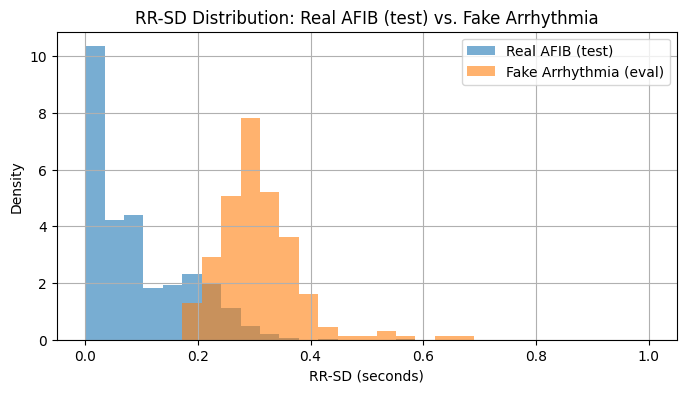

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ─── Define sampling frequency ───────────────────────────────────────────
fs = 100  # 100 Hz (1000 samples = 10 seconds)

# ─── 10.1.1) Compute RR‐SD on real test AFIB subset ────────────────────────
rr_sd_real_test = []
for i in range(ECGs_arr_test.shape[0]):
    lead1 = ECGs_arr_test[i][:, 0]  # Lead I
    # find_peaks needs distance in samples, so fs * 0.4 = 0.4 seconds = 40 samples
    peaks, _ = find_peaks(lead1, distance=fs * 0.4, height=0.05)
    if len(peaks) < 2:
        rr_sd_real_test.append(0.0)
    else:
        rr_intervals = np.diff(peaks) / fs
        rr_sd_real_test.append(np.std(rr_intervals))

rr_sd_real_test = np.array(rr_sd_real_test)

# ─── 10.1.2) Compute RR‐SD on fake arrhythmias (generated above) ─────────
rr_sd_fake_eval = []
for i in range(fake_arr_evaluate.shape[0]):
    lead1 = fake_arr_evaluate[i][:, 0]
    peaks, _ = find_peaks(lead1, distance=fs * 0.4, height=0.05)
    if len(peaks) < 2:
        rr_sd_fake_eval.append(0.0)
    else:
        rr_intervals = np.diff(peaks) / fs
        rr_sd_fake_eval.append(np.std(rr_intervals))

rr_sd_fake_eval = np.array(rr_sd_fake_eval)

# ─── 10.1.3) Print summary stats ──────────────────────────────────────────
print(f"Real AFIB (test) RR-SD → mean = {rr_sd_real_test.mean():.3f}s,  std = {rr_sd_real_test.std():.3f}s")
print(f"Fake Arr Eval        RR-SD → mean = {rr_sd_fake_eval.mean():.3f}s,  std = {rr_sd_fake_eval.std():.3f}s")

# ─── 10.1.4) Plot histograms side by side ─────────────────────────────────
bins = np.linspace(0, 1.0, 30)

plt.figure(figsize=(8, 4))
plt.hist(rr_sd_real_test, bins=bins, density=True, alpha=0.6, label="Real AFIB (test)")
plt.hist(rr_sd_fake_eval, bins=bins, density=True, alpha=0.6, label="Fake Arrhythmia (eval)")
plt.title("RR-SD Distribution: Real AFIB (test) vs. Fake Arrhythmia")
plt.xlabel("RR-SD (seconds)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from scipy.stats import entropy

# 10.2.1) Build normalized histograms over same bins
counts_real, _ = np.histogram(rr_sd_real_test, bins=bins, density=False)
counts_fake, _ = np.histogram(rr_sd_fake_eval, bins=bins, density=False)

# Add a tiny constant to avoid zero counts before normalizing
counts_real = counts_real.astype(np.float32) + 1e-8
counts_fake = counts_fake.astype(np.float32) + 1e-8

# Normalize to get probability distributions
p = counts_real / np.sum(counts_real)
q = counts_fake / np.sum(counts_fake)

# 10.2.2) Compute KL divergence
kl_divergence = entropy(p, q)
print(f"KL Divergence (Real AFIB || Fake Arrhythmia) = {kl_divergence:.4f}")


KL Divergence (Real AFIB || Fake Arrhythmia) = 17.1786


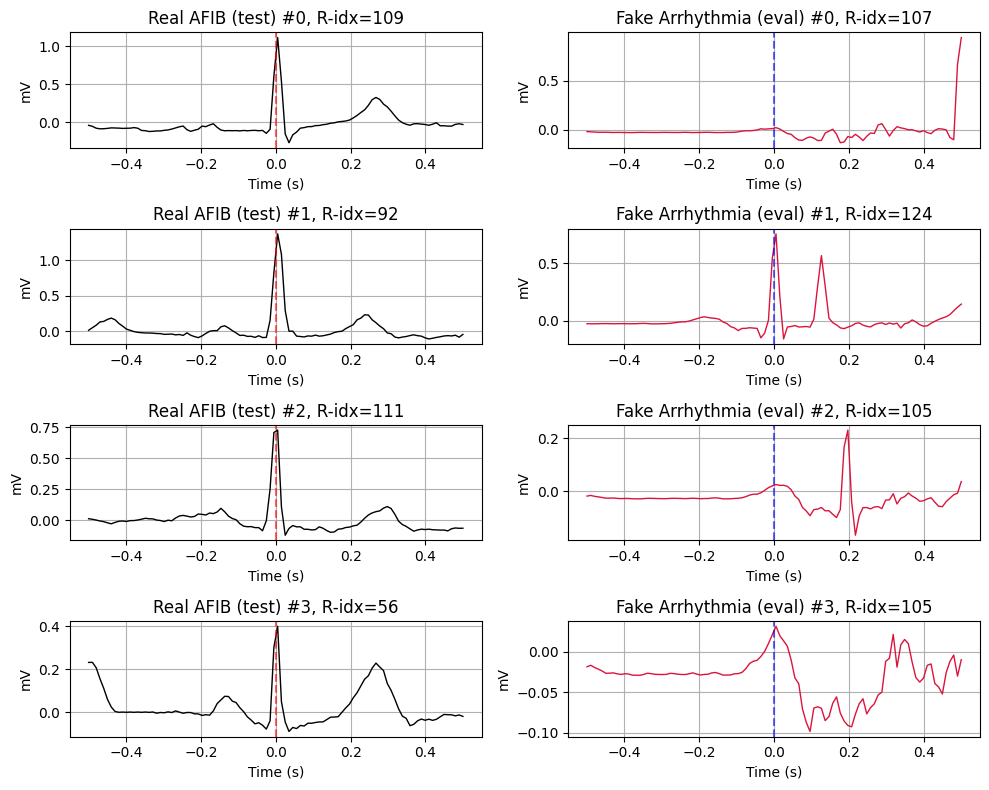

In [20]:
# 10.3.1) Reuse helper to extract ±0.5 s beat windows
def extract_single_beats(ecg_set, n_examples=4, fs=100, half_window=50, threshold=0.05):
    windows = []
    count = 0
    while len(windows) < n_examples and count < ecg_set.shape[0]:
        sig = ecg_set[count, :, 0]  # Lead I
        peaks, _ = find_peaks(sig, distance=fs*0.4, height=threshold)
        if len(peaks) == 0:
            count += 1
            continue
        for rpos in peaks:
            if rpos - half_window >= 0 and rpos + half_window < sig.shape[0]:
                win = sig[rpos - half_window : rpos + half_window]
                windows.append((count, rpos, win))
                break
        count += 1
    return windows

# 10.3.2) Extract 4 real AFIB windows (from test set)
real_test_windows = extract_single_beats(ECGs_arr_test, n_examples=4, fs=fs, half_window=50, threshold=0.05)

# 10.3.3) Extract 4 fake arrhythmia windows
fake_eval_windows = extract_single_beats(fake_arr_evaluate, n_examples=4, fs=fs, half_window=50, threshold=0.0)

# 10.3.4) Plot side by side
time_axis = np.linspace(-0.5, 0.5, 100)

plt.figure(figsize=(10, 8))
for i in range(4):
    ridx, rpos, rwin = real_test_windows[i]
    fidx, fpos, fwin = fake_eval_windows[i]

    # Real AFIB beat
    plt.subplot(4, 2, 2*i + 1)
    plt.plot(time_axis, rwin, color="black", linewidth=1)
    plt.axvline(0, color="red", linestyle="--", alpha=0.6)
    plt.title(f"Real AFIB (test) #{ridx}, R-idx={rpos}")
    plt.xlabel("Time (s)")
    plt.ylabel("mV")
    plt.grid(True)

    # Fake Arrhythmia beat
    plt.subplot(4, 2, 2*i + 2)
    plt.plot(time_axis, fwin, color="crimson", linewidth=1)
    plt.axvline(0, color="blue", linestyle="--", alpha=0.6)
    plt.title(f"Fake Arrhythmia (eval) #{fidx}, R-idx={fpos}")
    plt.xlabel("Time (s)")
    plt.ylabel("mV")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import roc_auc_score

# 11.1) Re‐build discriminator & load its final weights
disc_eval = build_discriminator(input_shape=(1000, 12), depth=2, use_residual=True)
disc_eval.load_weights(os.path.join(save_directory, "discriminator_arrhythmia_final.weights.h5"))
print("✅ Loaded arrhythmia‐GAN discriminator weights for evaluation.")

# 11.2) Sample 200 real AFIB from the test set
N_eval = 200
real_idx_eval = np.random.choice(ECGs_arr_test.shape[0], N_eval, replace=False)
real_eval     = ECGs_arr_test[real_idx_eval]  # (200,1000,12)

# 11.3) Generate 200 fake arrhythmia ECGs
z_eval2      = np.random.randn(N_eval, 1, latent_dim).astype("float32")
fake_eval2   = gen_eval.predict(z_eval2, verbose=1)  # (200,1000,12)

# 11.4) Build combined dataset + labels
X_score = np.vstack([real_eval, fake_eval2])           # shape = (400,1000,12)
y_score = np.concatenate([np.ones((N_eval,1)),         # real=1
                          np.zeros((N_eval,1))])       # fake=0

# 11.5) Get D’s predictions
preds_score = disc_eval.predict(X_score, batch_size=32, verbose=1).flatten()

# 11.6) Compute AUROC + accuracy
auroc_score = roc_auc_score(y_score.flatten(), preds_score)
acc_score   = np.mean((preds_score >= 0.5).astype(int) == y_score.flatten())

print(f"Held-out Discriminator AUROC: {auroc_score:.4f}")
print(f"Held-out Discriminator Accuracy (p=0.5): {acc_score:.3f}")


✅ Loaded arrhythmia‐GAN discriminator weights for evaluation.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Held-out Discriminator AUROC: 0.9552
Held-out Discriminator Accuracy (p=0.5): 0.902
